# Bed Posture and Subject Classification

In [1]:
# Set which GPU to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [28]:
# Import Libraries

import numpy as np
import pandas as pd
import os
import sys
import time
from PIL import Image

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

# Other
import math
import h5py
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

%matplotlib inline
np.random.seed(123)

## Data Load and preprocessing

We used data from the first experiment in the public PmatData dataset.

Information about the dataset:
- Samples are collected using Vista Medical FSA Soft- Flex 2048
- The main data folder contains 13 directories corresponding to 13 subjects. Each folder contains 17 txt files, which correspond to the 17 possible sleeping postures (8 standard and 9 uncommon postures)
- Each file contains multiple recordings of the subject posture in the form of pressure matrices, sampled at 1Hz. Each row is length 2,048 representing the 64x32 pressure mat size. Pressure ratings range from 0 to 1000
- 2-mins (around 120 frames) of data was recorded per subject

Source of dataset: https://physionet.org/content/pmd/1.0.0/

In [29]:
path = os.getcwd()

In [30]:
# Table of Subject Information
subj_inf = pd.read_csv(path + '/data/experiment-i/subject-info-i.csv', encoding = 'utf_16', index_col='Subject-Number')
display(subj_inf)

,Age,Height/cm,Weight/kg
Subject-Number,,,
1,19,175,87
2,23,183,85
3,23,183,100
4,24,177,70
5,24,172,66
6,26,169,83
7,27,179,96
8,27,186,63
9,30,174,74


In [4]:
# List of Subjects in Experiment I
subj_list = [file for file in os.listdir(path +'/data/experiment-i/') if os.path.isdir(os.path.join(path +'/data/experiment-i/', file))]
print(f"The subjects in Experiment I are: {subj_list}")

The subjects in Experiment I are: ['S9', 'S10', 'S12', 'S7', 'S6', 'S4', 'S1', 'S8', 'S11', 'S3', 'S13', 'S2', 'S5']


In [5]:
# Number of Positions for Each Subject
positions_cnt = [file for file in os.listdir(path +'/data/experiment-i/S5/') if os.path.isfile(os.path.join(path +'/data/experiment-i/S5/', file))]
print(f"The number of positions for each subject are: {len(positions_cnt)}")

The number of positions for each subject are: 17


In [6]:
# macro position vector
positions_i = ["placeholder", "supine", "right",
                     "left", "right", "right",
                     "left", "left", "supine",
                     "supine", "supine", "supine",
                     "supine", "right", "left",
                     "supine", "supine", "supine"]

In [7]:
# Use position names to define 3 common positions

def token_position(x):
    return {
        'supine': 0,
        'left': 1,
        'right': 2,
        'left_fetus': 1,
        'right_fetus': 2
    }[x]

In [50]:
# Specific position vector

positions_ii = ['placeholder', 'supine','right','left','right_30_roll','right_60_roll','left_30_roll','left_60_roll','supine_star','supine_hand_crossed','supine_knees_up','supine_right_knee_up','supine_left_knee_up','right_fetus','left_fetus','supine_30_inclination','supine_45_inclination','supine_60_inclination']

In [41]:
# Inspect one file
test_read = np.loadtxt(path + '/data/experiment-i/S6/1.txt')
test_read.shape # (101, 2048) = (number of samples, number of sensors (32x64))

(107, 2048)

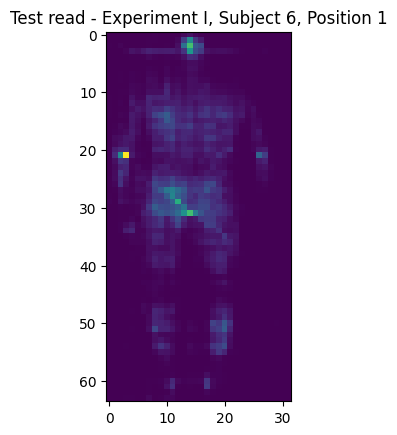

In [43]:
# Example of one sample
plt.title("Test read - Experiment I, Subject 6, Position 1")
plt.imshow(test_read[21,:].reshape(64, 32)) # 20th sample
plt.show()

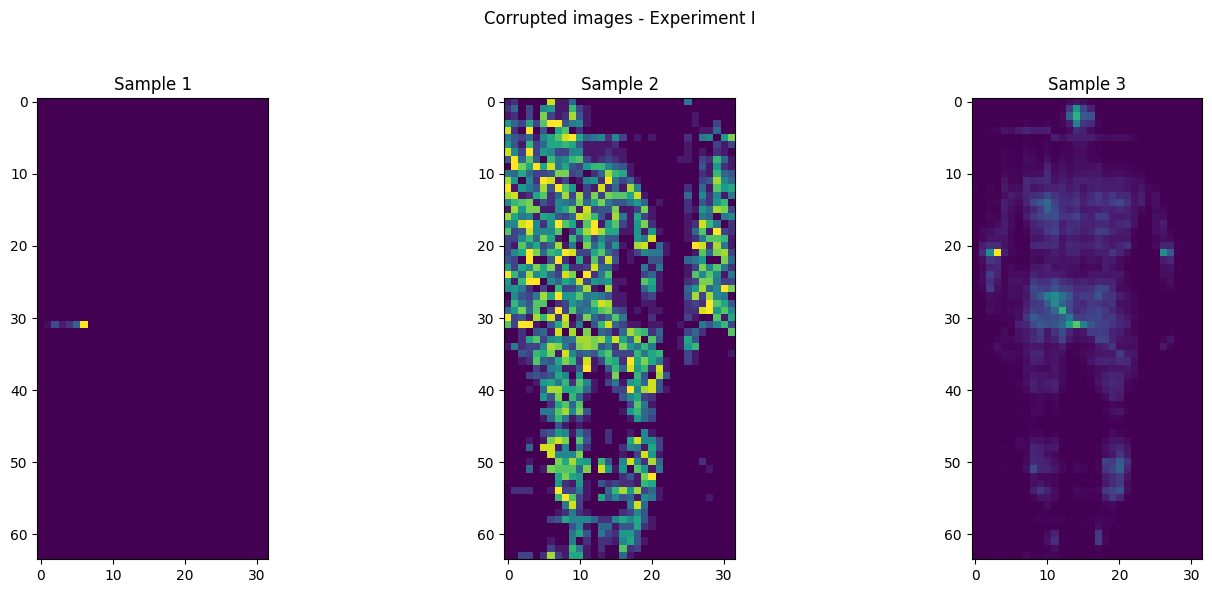

In [48]:
# Show that first three samples are corrupted
fig, axes = plt.subplots(figsize=(15, 6), ncols=3)
fig.suptitle("Corrupted images - Experiment I")

# Plot the first three samples
for ii in range(3):
    ax = axes[ii]
    ax.imshow(test_read[ii, :].reshape(64, 32))
    ax.set_title(f"Sample {ii+1}")


# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()


In [58]:
# Load all the data into a dictionary, where the keys are the subjects and 
# values: images (index 0), position's number (index 1), and specific position's name (index 2)

# Initialize dictionary to store the data
exp_i_data = {}

# Directory structure: /data/experiment-i/subject/position.txt
for _, dirs, _ in os.walk(path + '/data/experiment-i/'):  
    # Loop through each subject
    for dir in dirs:
        subject = dir
        data = None
        labels = None
        # Loop through each position file in the subject's directory
        for _, _, files in os.walk(path + '/data/experiment-i/' + dir):
            for file in files:
                # Posture path
                file_path = path + '/data/experiment-i/' + dir + '/' + file
                with open(file_path, 'r') as f:
                    # We remove first and last 3 corrupted frames - suggestion from the dataset's authors
                    for line in f.read().splitlines()[3:-3]:
                        raw_data = np.fromstring(line, dtype=float, sep='\t').reshape(1, 64, 32)
                        # apply median filter of 3x3
                        raw_data = ndimage.median_filter(raw_data, size=(1,3,3))
                        # Normalize the data: change range from [0-1000] to [0-255]
                        file_data = np.round(raw_data*255/1000).astype(np.uint8)
                        # Label the data using position number from file name
                        file_label = token_position(positions_i[int(file[:-4])])                        
                        file_label = np.array([file_label])

                        # Specific position label
                        position_label = positions_ii[int(file[:-4])]
                        position_label = np.array([position_label])

                        # Specify position index for models
                        position_index = int(file[:-4])-1
                        position_index = np.array([position_index])

                        if data is None:
                            data = file_data
                        else:
                            # Concatenate the new data along the first axis
                            data = np.concatenate((data, file_data), axis=0)
                        if labels is None:
                            labels = file_label
                            positions = position_label
                            position_indices = position_index
                        else:
                            labels = np.concatenate((labels, file_label), axis=0)
                            positions = np.concatenate((positions, position_label), axis=0)
                            position_indices = np.concatenate((position_indices, position_index), axis=0)
                        
        exp_i_data[subject] = {'data': data, 'labels': labels, 'position_indices': position_indices, 'positions': positions}

#### CNN

In [12]:
# Tokenize the labels
def token_patient(x):
    return {'S1': 0, 'S2': 1, 'S3': 2, 'S4': 3, 'S5': 4,  'S6': 5, 'S7': 6,
                    'S8': 7, 'S9': 8, 'S10': 9, 'S11': 10, 'S12': 11, 'S13':12}[x]

In [13]:
# Create datasets for each experiment

# Experiment I
X = exp_i_data[subj_list[0]]['data']
y = exp_i_data[subj_list[0]]['labels']
label_s = np.full(len(X), token_patient(subj_list[0]))

for subject in subj_list[1:]:
    X = np.append(X, exp_i_data[subject]['data'], axis=0)
    y = np.append(y, exp_i_data[subject]['labels'], axis=0)
    label_s = np.append(label_s, np.full(len(exp_i_data[subject]['data']), token_patient(subject)))

In [14]:
# print the shapes of the datasets
print(f"Experiment I: X shape: {X.shape}, y shape: {y.shape}")

Experiment I: X shape: (18698, 64, 32), y shape: (18698,)


In [18]:
# Train-Test Split

# 10% was used for testing and 90% for training.

# Experiment I
# indices = np.arange(len(X))
# X_train, X_test, y_train, y_test, indices_train, indices_test, = train_test_split(X, y, indices, test_size=0.1, random_state=123)

# # Split label_s accordingly using indices
# label_s_train = label_s[indices_train]
# label_s_test = label_s[indices_test]

In [19]:
# label_s_train = tf.keras.utils.to_categorical(label_s_train, num_classes=13)
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)

In [20]:
# Print the shapes of the training and testing datasets

# print(f"Experiment I: Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
# print(f"Experiment I: Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Experiment I: Training data shape: (16828, 64, 32), Training labels shape: (16828, 3)
Experiment I: Testing data shape: (1870, 64, 32), Testing labels shape: (1870,)


In [15]:
# Define the proposed model from paper

# can't use a sequential model as model has multiple outputs
#each convolutional block was followed by an increasing dropout rate of 10%, 20%, 30%, 40%. 

# Define the functional model
def create_model(regularization=0):

    input = tf.keras.Input(shape=(64, 32, 1), name="img")
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1,1), padding='valid', kernel_regularizer=l2(regularization))(input)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.GlobalMaxPool2D()(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    subject_output = tf.keras.layers.Dense(13, activation='softmax', name="subject_output")(x)
    posture_output = tf.keras.layers.Dense(3, activation='softmax', name="posture_output")(x)

    base_cnn_model = tf.keras.Model(inputs=input, outputs=[subject_output,posture_output], name="base_cnn_model")

    return base_cnn_model
    # From Figure 2 in paper

    # Input: 32x64x1

    # 4 main blocks of conv-batchnorm plus max pool for 1st 2 blocks
    # 1st block: 30 x 62 x 32 of conv-batchnorm-maxpool-leakyrelu (32 filters applied), max pool would make each 30x 62 =10 x 20, cov would make (32-3+1)x(64-3+1) = 30 x 62
    # 2nd block: 13 x 29 x 64 of conv-batchnorm-maxpool-leakyrelu
    # 3rd block: 4 x 12 x 128 of conv-batchnorm-leakyrelu
    # 4th block: 2 x 10 x 256 of conv-batchnorm-leakyrelu

    # Two Dense layers of 256 units with dropout of 0.5
    # Two output layers, multinomial logistic regressors for recognition of subjects (M units) and their sleep postures (N units)

    # Loss function: multiclass cross-entropy loss function of subjects and users separately
    # plus combined loss function of both with hyperparameter lambda (from 0 to 1)

    # Conv kernels: 3x3, stride 1, padding valid
    # Max pool: 3x3
    # batch norm
    # Leaky ReLU: alpha 0.2

    # dense layers have dropout of 0.5

    # each conv block was followed by increasing drop of .1, .2, .3, .4

    # L2 reg loss with coefficient of 0.002
    # 2 softmax regressors

In [83]:
# Preprocessing

# median filter of 3x3
# remove first and last 3 frames of each sequence
# threshold filtering and equalization histogram

### Loss Functions for Training

### Notation
- Let $I$ be the input pressure map.
- Let $i$ be the example index.
- Let $\gamma$ and $\delta$ be the user and the posture, respectively
- Let M and N be the number of users and postures, respectively

### Multi-Class Cross Entropy Loss Functions

User Loss:

$$ L_{user} = - \sum_{j=1}^{M} \gamma_{ij} \log P({\gamma_{j}}|I_i)$$


Posture Loss:

$$ L_{posture} = - \sum_{j=1}^{N} \delta_{ij} \log P({\delta_{j}}|I_i)$$

Combined Loss

$$ L = \lambda L_{user} + (1-\lambda)L_{posture} $$

where $\lambda$ is a hyperparameter that enforces the tradeoff between the two objectives - separating users and detecting postures

In [16]:
def custom_loss(lambd):
    # Define separate loss functions for each output
    def user_loss(y_true, y_pred):
        return tf.keras.losses.categorical_crossentropy(y_true[0], y_pred[0])

    def posture_loss(y_true, y_pred):
        return tf.keras.losses.categorical_crossentropy(y_true[1], y_pred[1])

    # Combine the losses with the specified lambda
    def combined_loss(y_true, y_pred):
        return lambd * user_loss(y_true, y_pred) + (1 - lambd) * posture_loss(y_true, y_pred)
    return combined_loss

In [17]:
# from tensorflow.keras.callbacks import LearningRateScheduler

# Initial learning rate
initial_learning_rate = 5e-4


In [18]:
y_oh = tf.keras.utils.to_categorical(y, num_classes=3)
label_s_oh = tf.keras.utils.to_categorical(label_s, num_classes=13)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

epochs = 40
batch_size = 64
regularization = 0
lambdas = [0.2, 0.5, 0.6, 0.8]

performances = {}
for lambd in lambdas:
    performances[lambd] = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold {i}:")
        base_cnn_model=create_model(regularization)
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        base_cnn_model.compile(optimizer = optimizer,
                loss=custom_loss(lambd),
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

        history = base_cnn_model.fit(
            X[train_index], 
            {
                'subject_output': label_s_oh[train_index], 
                'posture_output': y_oh[train_index]
            },
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(
                X[test_index], 
                {
                    'subject_output': label_s_oh[test_index], 
                    'posture_output': y_oh[test_index]
                }
            )
        )
        
        performances[lambd].append([history.history["val_subject_output_categorical_accuracy"], history.history["val_posture_output_categorical_accuracy"]])



In [24]:
# mean performances for each lamda on subject [0] or posture [1] accuracy

print('Mean performance for each lambda on subject accuracy')
print([np.mean(np.max([el[0] for el in perf], axis=1)) for perf in performances.values()])
print('----------------------------------------------------')
print('Mean performance for each lambda on posture accuracy')
print([np.mean(np.max([el[1] for el in perf], axis=1)) for perf in performances.values()])

Mean performance for each lambda on subject accuracy
[0.5157762408256531, 0.5996379733085633, 0.6129009485244751, 0.5156704246997833]
----------------------------------------------------
Mean performance for each lambda on posture accuracy
[0.9995721817016602, 0.9995721817016602, 0.9995186686515808, 0.9996791124343872]
